# Libraries

In [2]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

# Feature Computation

In [14]:
# We are going to define three steps for the computation:
# - Apply the mel filters on the windowed spectrum of the signal
# - Take the logarithm scale of the results
# - Apply the Discrete Cosine Transform

def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft( # Short Time Fourier Transform on the windowed signal
        audio,
        window='hamming', # Windowing
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram with dot product
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

## Computing the Training Features

In [29]:
classes = ['blues', 'hiphop', 'metal', 'reggae']

n_mfcc = 18 # number of mel filter coefficients
dict_train_features = {'blues': [], 'hiphop': [], 'metal': [], 'reggae': []}

# We are analysing 70 tracks for each genre in this training step
for c in classes:
    train_root = 'Input_Audio_Files/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_mfcc))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        train_features[index, :] = np.mean(mfcc, axis=1)
        
    dict_train_features[c] = train_features

FileNotFoundError: [Errno 2] No such file or directory: 'Input_Audio_Files/blues/training/'

In [15]:
# load the last WAV file in order to check if it correctly upload the training files (there should be a reggae track)
ipd.Audio(audio, rate=fs) 

## Features Visualisation

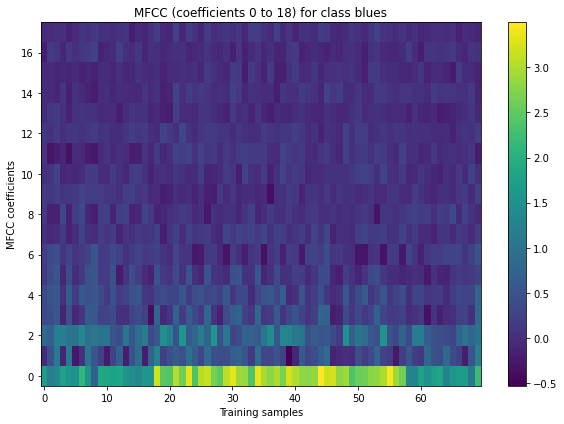

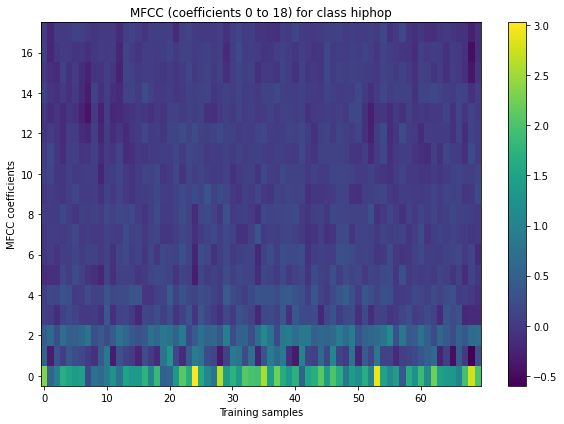

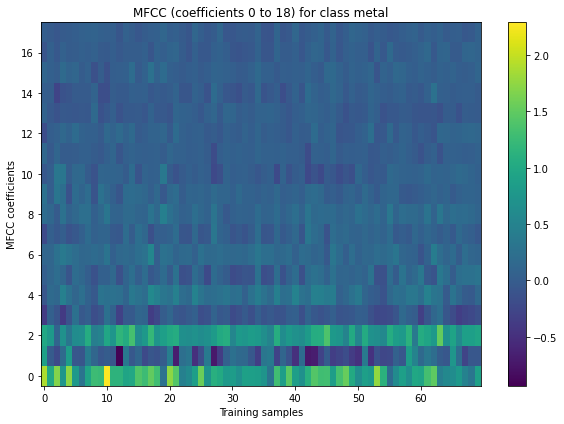

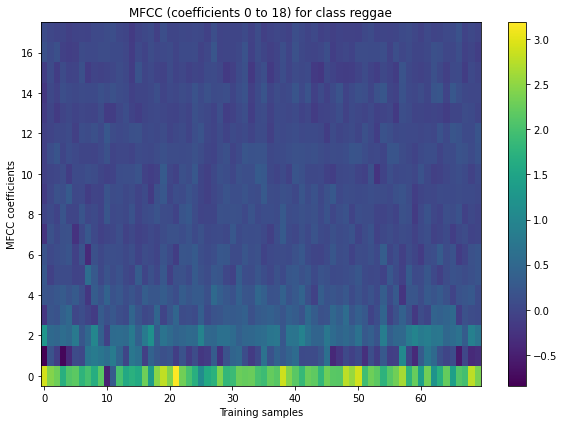

In [28]:
# We are going to visualise the MFCC coefficients matrix for each genre

for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Features Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 18) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    """ 
    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()
    """


# SVM Classification

In [26]:
class_0 = 'blues'
class_1 = 'hiphop'
class_2 = 'metal'
class_3 = 'reggae'

# Train step
X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]
X_train_3 = dict_train_features[class_3]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2
y_train_3 = np.ones((X_train_3.shape[0],))*3

#y_train = np.concatenate((y_train_class_0, y_train_class_1, y_train_class_2, y_train_class_3), axis=0)

In [27]:
# Test step
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]
X_test_3 = dict_test_features[class_3]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2
y_test_3 = np.ones((X_test_3.shape[0],))*3

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

NameError: name 'dict_test_features' is not defined